In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px

import warnings

warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from xgboost import XGBClassifier

In [74]:
wine = pd.read_csv("wine-quality-white-and-red.csv")
wine

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.270,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6
1,white,6.3,0.300,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6
2,white,8.1,0.280,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6
3,white,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
4,white,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,red,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
6493,red,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
6494,red,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
6495,red,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [76]:
wine.drop(columns=['type'], inplace = True)

In [78]:
wine['quality'].value_counts()

quality
6    2836
5    2138
7    1079
4     216
8     193
3      30
9       5
Name: count, dtype: int64

In [80]:
wine.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

<Axes: >

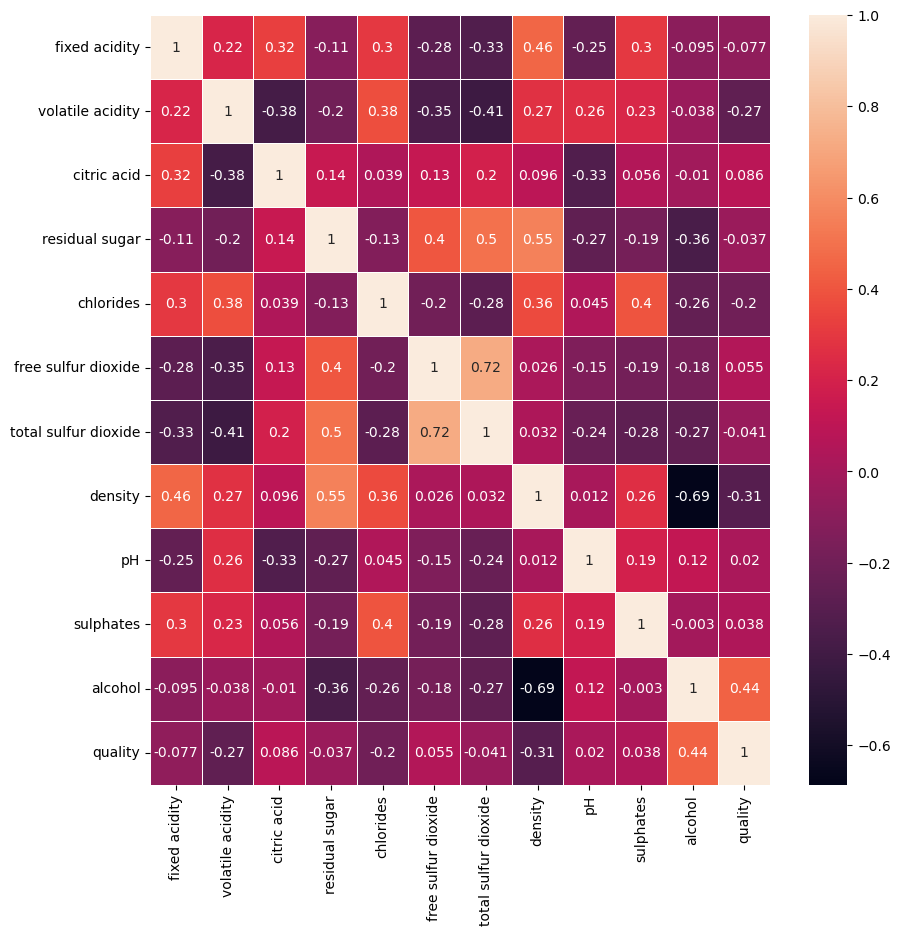

In [82]:
corr_matrix = wine.corr().abs()
f, axis = plt.subplots(figsize=(10, 10))
sns.heatmap(wine.corr(), annot= True, linewidths = 0.5,ax = axis)

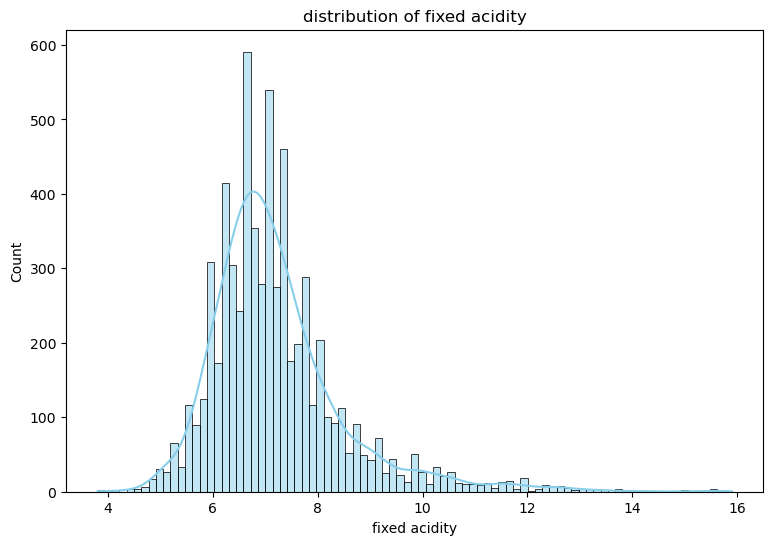

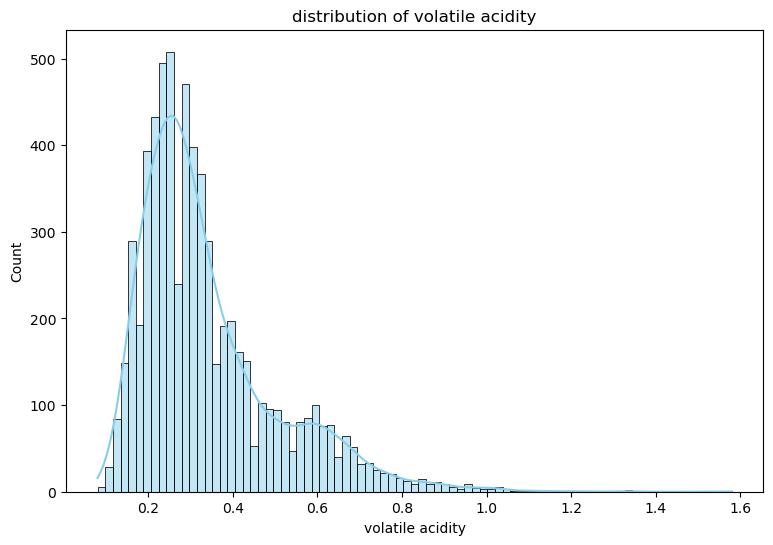

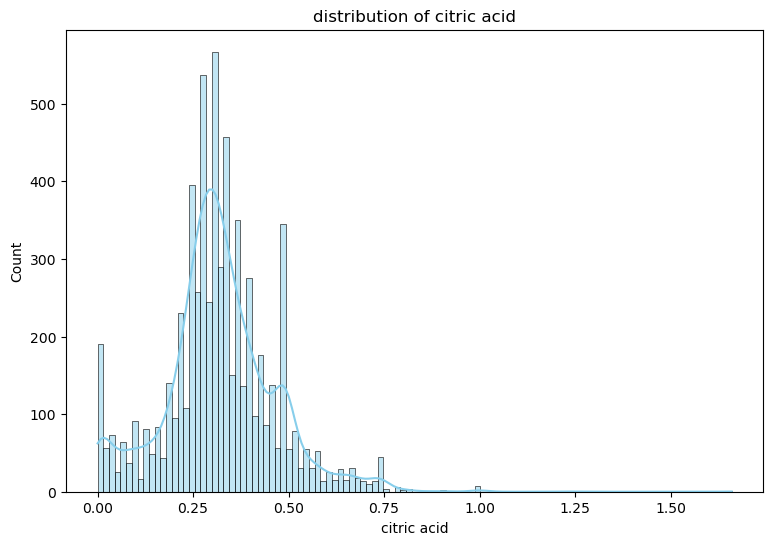

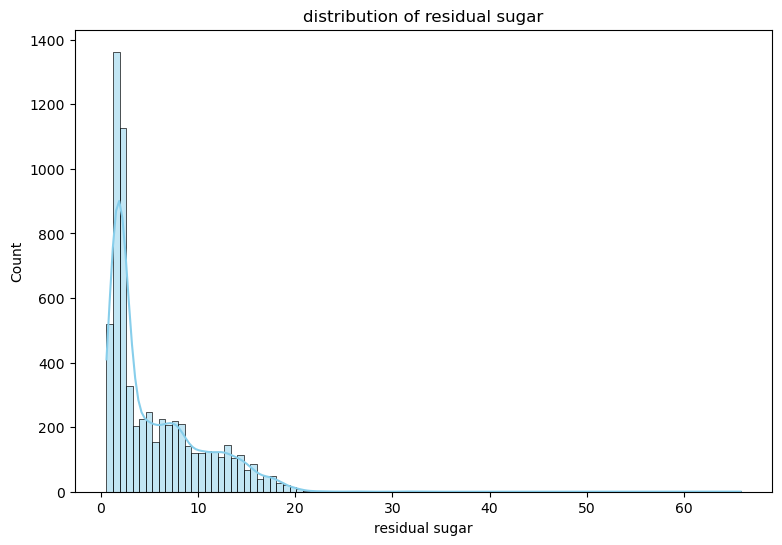

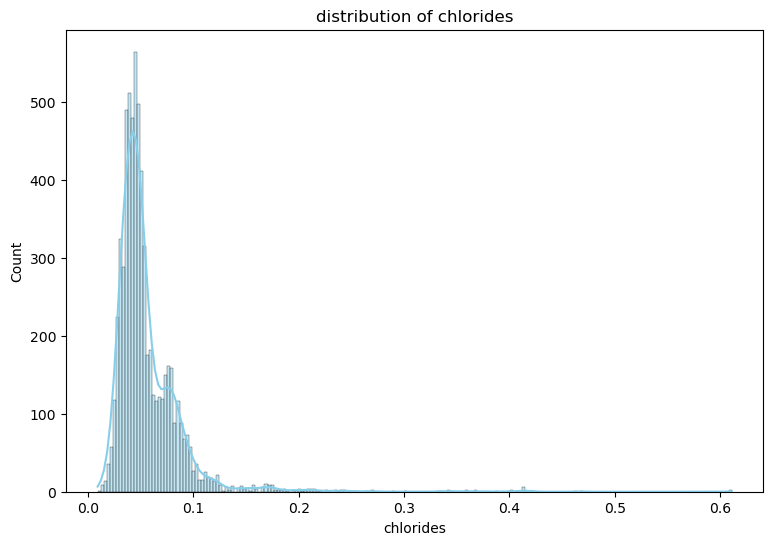

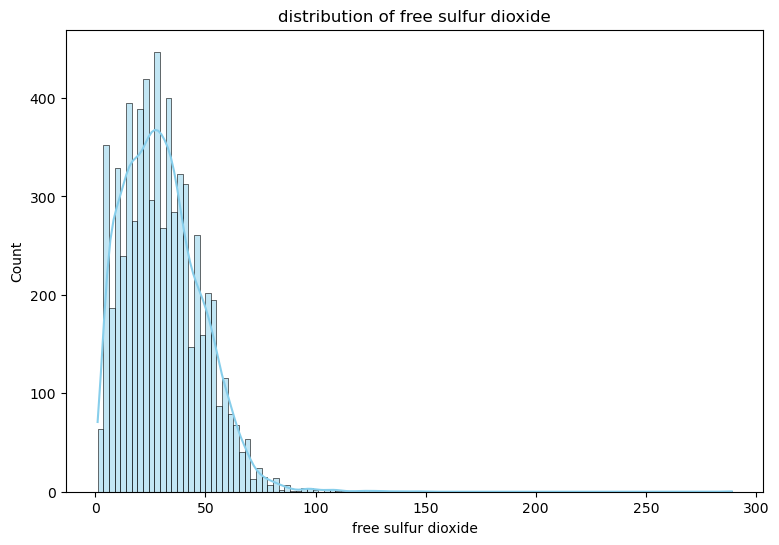

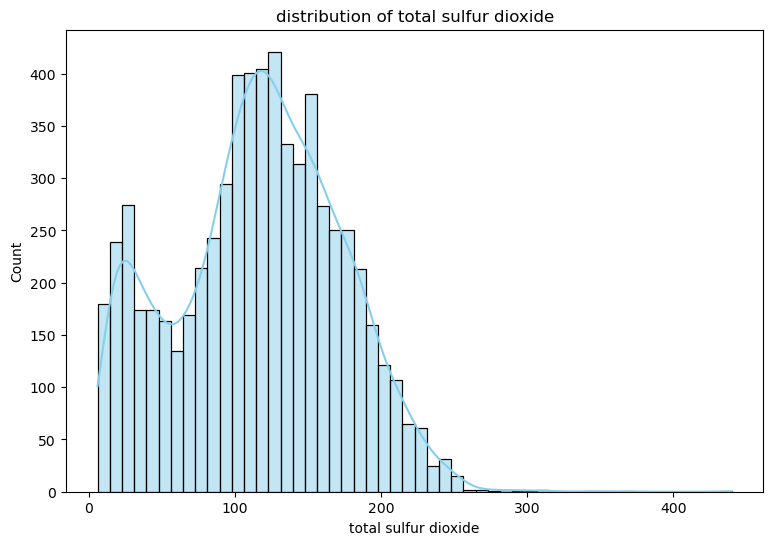

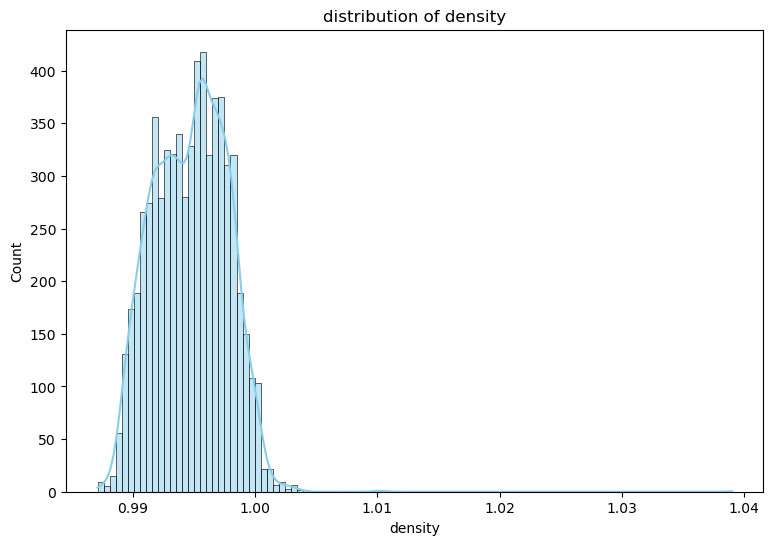

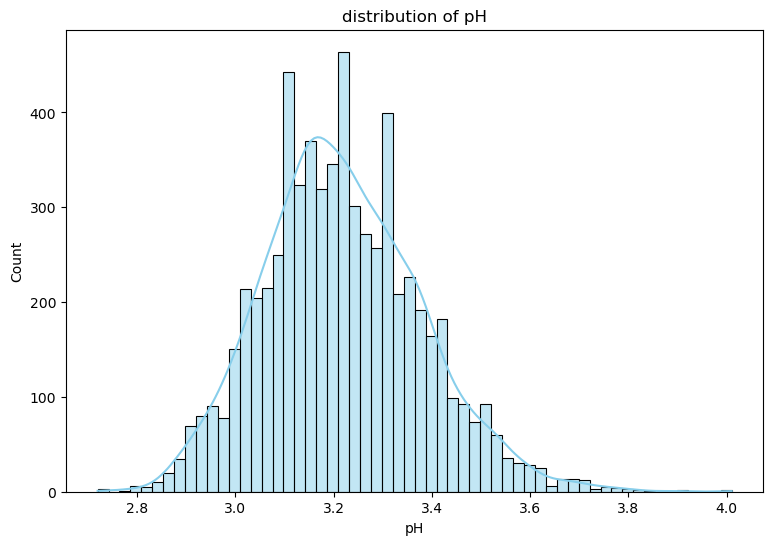

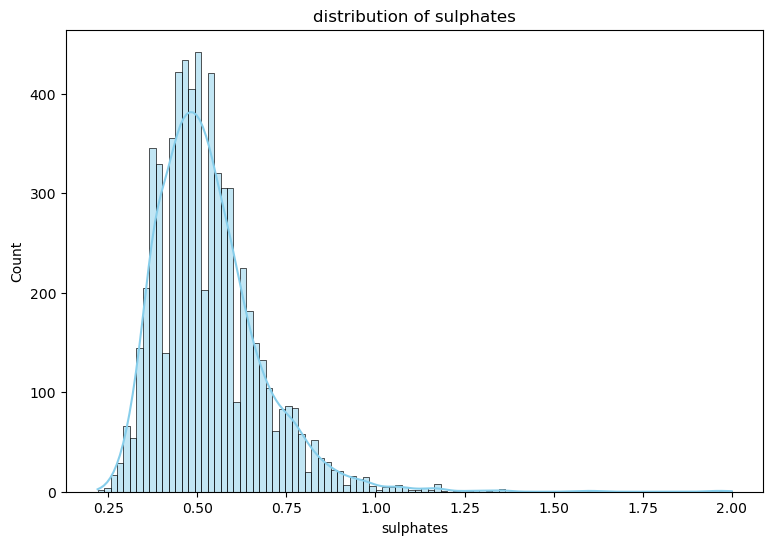

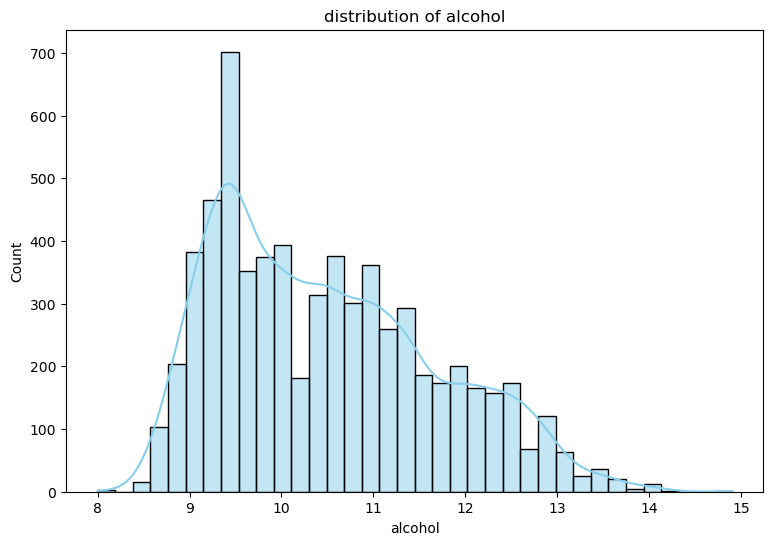

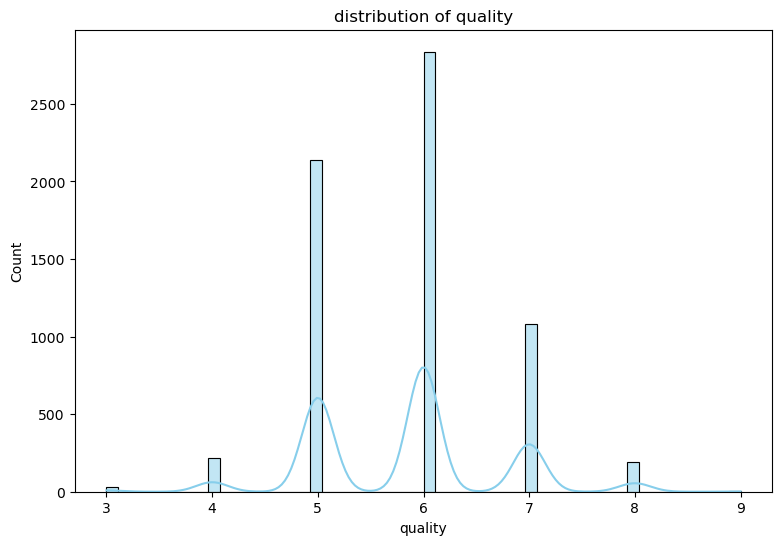

In [84]:
column = wine.columns.tolist()
for column in wine:
    plt.figure(figsize=(9,6))
    sns.histplot(data = wine,x = column, kde= True, color = 'skyblue')
    plt.title(f'distribution of {column}')
    plt.show()

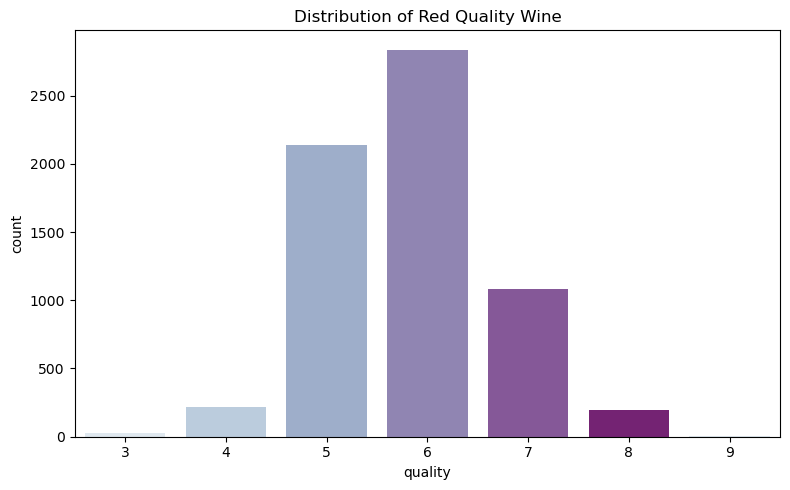

In [85]:
labels = ["3", "4", "5", "6", "7", "8","9"]
ticks = range(len(labels))

fig, ax = plt.subplots(figsize=(8, 5))

# Plot the count plot
sns.countplot(data=wine, x='quality', ax=ax, palette=sns.color_palette("BuPu"))
ax.set_title('Distribution of Red Quality Wine')
ax.set_xticks(ticks)
ax.set_xticklabels(labels)

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()


In [86]:
X = wine.drop(columns=["quality","fixed acidity"])
y = wine["quality"]

original_columns = X.columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Standardizing the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Training the RandomForestClassifier
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Making predictions
y_pred = model.predict(X_test)

# Get feature importances from the model
importance_1 = model.feature_importances_
importances = sorted(zip(original_columns, importance_1), key=lambda x: x[1], reverse=True)

# Calculate the corr matrix
corr_matrix = pd.DataFrame(X_train, columns=original_columns).corr().abs()

# Select the upper triangle of the correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Threshold for high correlation
high_corr_threshold = 0.66

# Find index of feature columns with corr > threshold
to_drop = [column for column in upper.columns if any(upper[column] > high_corr_threshold)]

# Filter based on feature importance
importance_threshold = 0.05
important_features = [name for name, importance in importances if importance > importance_threshold]
final_features = [feature for feature in important_features if feature not in to_drop]

# Use the final_features to filter the original dataset
X_reduced = wine[final_features]

# Split the reduced data
X_train_reduced, X_test_reduced, y_train_reduced, y_test_reduced = train_test_split(X_reduced, wine["quality"], test_size=0.2, random_state=42)

# Scale the reduced data
X_train_reduced = scaler.fit_transform(X_train_reduced)
X_test_reduced = scaler.transform(X_test_reduced)

# Train the model using the reduced data
model_reduced = RandomForestClassifier(random_state=42)
model_reduced.fit(X_train_reduced, y_train_reduced)

# Predict using the reduced data
y_pred_reduced = model_reduced.predict(X_test_reduced)

In [90]:
print("Classification Report:\n", classification_report(y_test_reduced, y_pred_reduced))
print("Confusion Matrix:\n", confusion_matrix(y_test_reduced, y_pred_reduced))
print("Accuracy Score:", accuracy_score(y_test_reduced, y_pred_reduced))

Classification Report:
               precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.88      0.15      0.26        46
           5       0.69      0.76      0.72       420
           6       0.65      0.77      0.71       579
           7       0.71      0.45      0.55       221
           8       0.70      0.22      0.33        32

    accuracy                           0.68      1300
   macro avg       0.61      0.39      0.43      1300
weighted avg       0.68      0.68      0.66      1300

Confusion Matrix:
 [[  0   0   1   1   0   0]
 [  0   7  26  12   1   0]
 [  0   0 318 101   1   0]
 [  0   1 103 446  28   1]
 [  0   0  10 109 100   2]
 [  0   0   1  13  11   7]]
Accuracy Score: 0.6753846153846154
